In [1]:
from elements.batteryModel import LithiumIonBattery, make_OCVfromSOCtemp, make_dOCVfromSOCtemp
from elements.estimator import SPKF
from elements.plots import plot_SOC
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mat4py import loadmat
from scipy.linalg import block_diag
from tqdm import tqdm

'''
############################## OCV and dOCV ##############################
data = loadmat('models/PANmodel.mat')
OCVfromSOC = make_OCVfromSOCtemp(data, 25)
dOCVfromSOC = make_dOCVfromSOCtemp(data, 25)
xnew = np.arange(0,1,0.01)
fnew = OCVfromSOC(xnew)
dfnew = dOCVfromSOC(xnew)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(data['model']['SOC'],data['model']['OCV0'])
plt.plot(xnew,fnew,linestyle='--')
plt.grid()
plt.subplot(1,2,2)
plt.plot(xnew,dfnew)
plt.grid()
plt.show()
'''

############################## Simulate Model ##############################
LIB1 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=1)
LIB1.z_k -= 0.2
udds = np.loadtxt("models/udds.txt")
ik = np.hstack([np.zeros(300), udds[:,1], np.zeros(300), udds[:,1], np.zeros(241)]*10)
time = np.arange(len(ik))/3600
voltages = np.zeros((len(time)))
SOCs = np.zeros((len(time)))


SigmaX = block_diag(1e2,1e-2,1e-3)  # uncertainty of initial state
SigmaW = block_diag(4e0)            # Uncertainty of current sensor, state equation
SigmaV = block_diag(3e-1)           # Uncertainty of voltage sensor, output equation

LIB1_SPKF = SPKF(LIB1, SigmaX, SigmaW, SigmaV)

for k,i in enumerate(ik):
    # currents[k] = i
    newState = LIB1.stateEqn(i)
    voltage = LIB1.outputEqn(i)
    LIB1.updateState(newState)

    voltages[k] = voltage
    SOCs[k] = LIB1.z_k.ravel()

vk = voltages
zk = SOCs
current = ik
voltage = vk
soc = zk



Ztrues = []
Zhats = []
Zbounds = []
V = []

for i in tqdm(range(len(current))):

    zhat, zbound = LIB1_SPKF.iter(current[i], voltage[i])

    # store data
    Ztrues.append(soc[i])
    Zhats.append(zhat)
    Zbounds.append(zbound)
    # V.append(v)


Ztrues = np.array(Ztrues)
Zhats = np.array(Zhats)
Zbounds = np.array(Zbounds)

100%|██████████| 36010/36010 [00:15<00:00, 2312.35it/s]


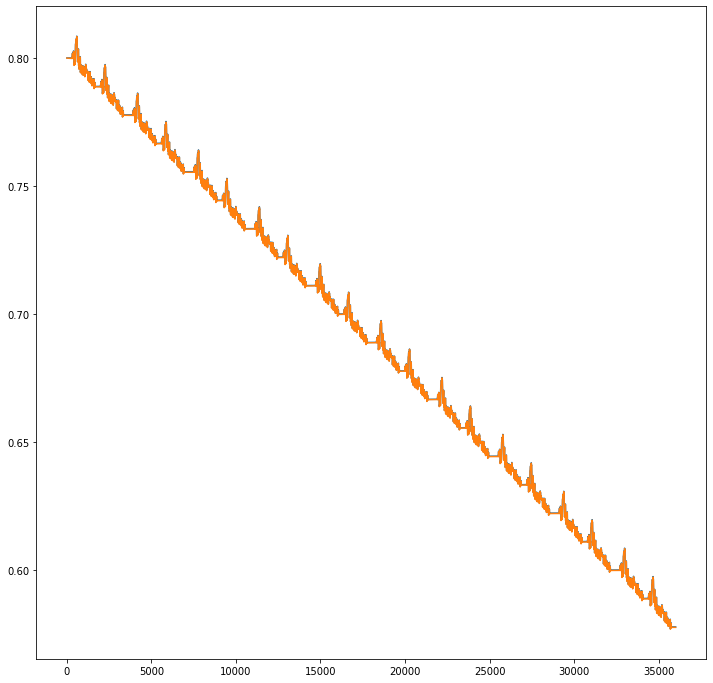

In [2]:
plt.figure(figsize=(12,12))
plt.plot(Ztrues)
plt.plot(Zhats)
